# <u>SUMMARY</u>

Notebook contains code used for:

- I. Downloading representative proteomes from GTDB
- II. Predicting optimal growth temperatures (OGTs) with TOME
- III. <b>Figure 2A.</b> Assessing correlations between empirical and predicted OGTs
- IV. <b>Figure 2B and S2.</b> Phylogentic Trees overlayed with OGT Data
- IV. <b>Figure 2C.</b> Comparing GTDB sample isolate-descriptions.

All code written for execution on AWS Parallel cluster.

## I. <i>SETUP</i>
Import libraries, define functions and download GTDB data.

In [26]:
#### IMPORT LIBS ####

# BASICS
import numpy as np
import pandas as pd
import os, glob
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

# STATS AND ML
from scipy import stats
from sklearn.linear_model import LinearRegression

# GRAPHING
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import matplotlib.pylab as pylab
import matplotlib.patches as mpatches
params = {'legend.fontsize': '10',
         'axes.labelsize': '12',
         'axes.titlesize':'12',
         'xtick.labelsize':'10',
         'ytick.labelsize':'10'}
pylab.rcParams.update(params)

# Palette
pub_red = "#ED2C78"
pub_darkest_grey = "#444546"
pub_dark_grey = "#86878A"
pub_medium_grey = "#B6B7B8" 
pub_light_grey = "#E0E1E1"
pub_cyan = "#92D9F6"
pub_orange = "#F89C44"

In [2]:
#### DEFINE FUNCTIONS ####

def write_bash_script(script_id, script_contents):
    """Write bash script from list of commands."""
    with open(script_id, "w") as f:
        f.writelines("\n".join(script_contents))
    return None

In [37]:
#### DOWNLOAD DATA: GTDB Representative Proteomes ####

# Script Name
script_name = "Download_GTDB_Proteomes.sh"

# Script Header
download_bash_script = ['#!/bin/bash','#SBATCH --job-name=Download_gtdb_proteomes', '#SBATCH --output=%j_%x_output.log', 
                        '#SBATCH --partition=cpu-c6i-16xlarge','#SBATCH --exclusive', "NUM_JOBS=$SLURM_CPUS_ON_NODE"]

# Data urls
proteome_url = "https://data.gtdb.ecogenomic.org/releases/release214/214.1/genomic_files_reps/gtdb_proteins_aa_reps_r214.tar.gz"
bac120_url = "https://data.gtdb.ecogenomic.org/releases/release214/214.1/bac120_metadata_r214.tsv.gz"
ar53_url = "https://data.gtdb.ecogenomic.org/releases/release214/214.1/ar53_metadata_r214.tsv.gz"

# Download GTDB
download_bash_script.append("# Download faa's and Metadata")
download_bash_script.append(f'wget -O {proteome_url.split("/")[-1]} "{proteome_url}"')
download_bash_script.append(f'wget "{bac120_url}"')
download_bash_script.append(f'wget "{ar53_url}"')
download_bash_script.append(f'echo "Download completed"')

# Extract
download_bash_script.append("# Extract")
download_bash_script.append(f'tar -xzvf {proteome_url.split("/")[-1]}')
download_bash_script.append(f'gunzip {bac120_url.split("/")[-1]}')
download_bash_script.append(f'gunzip {ar53_url.split("/")[-1]}')
download_bash_script.append(f'echo "Extraction complete"')

# Unzip and format faa's: TOME will only analyze unzipped files with .fasta suffix
download_bash_script.append("# Unzip and rename faa's")
download_bash_script.append("cd protein_faa_reps/archaea && parallel --gnu gunzip ::: *.gz")
download_bash_script.append('for file in *.faa; do mv "$file" "${file%.faa}.fasta"; done')
download_bash_script.append("cd ../bacteria && parallel --gnu gunzip ::: *.gz")
download_bash_script.append('for file in *.faa; do mv "$file" "${file%.faa}.fasta"; done')
download_bash_script.append(f'echo "Unzip and rename complete"')

# Download TOME
download_bash_script.append("# Download TOME")
download_bash_script.append('wget  -P /home/ubuntu/software/Manuscript -O TOME_Training_set.tsv "https://zenodo.org/records/1175609/files/temperature_data.tsv?download=1"')
                            
# Write script
write_bash_script(script_name, download_bash_script)

# Run
#os.system(f"sbatch {script_name}")

## II. <i>TOME OGT PREDICTION</i>
Calculate OGT for each representative species in GTDB Release 214, using their provided representative protein FASTAs. Write script for execution on AWS Parallel cluster.

- <b>Maunscript</b>: Machine Learning Applied to Predicting Microorganism Growth Temperatures and Enzyme Catalytic Optima
Gang Li, Kersten S. Rabe, Jens Nielsen, and Martin K. M. Engqvist
ACS Synthetic Biology 2019 8 (6), 1411-1420
DOI: 10.1021/acssynbio.9b00099
- Github: https://github.com/EngqvistLab/Tome

In [7]:
#### CONFIGURE BASH SCRIPT ####

# Data dirs: Tome will loop through all faa's in below directories
bact_dir="/mnt/efs/fs1/datasets/gtdb/representative_proteins_r214/protein_faa_reps/bacteria/"
arc_dir="/mnt/efs/fs1/datasets/gtdb/representative_proteins_r214/protein_faa_reps/archaea/"

# Out file names
tome_bact_out = "predicted_ogt_bacteria_v11302023.tsv"
tome_arc_out = "predicted_ogt_archaea_v11302023.tsv"

# Script Name
script_name = "Run_Tome.sh"

# Script Header
tome_bash_script = ['#!/bin/bash','#SBATCH --job-name=Tome', '#SBATCH --output=%j_%x_output.log',
                   '#SBATCH --partition=cpu-c6i-16xlarge','#SBATCH --exclusive','#SBATCH --nodes=4', 
                   "# ACTIVATE CONDA", "source /home/ubuntu/anaconda3/etc/profile.d/conda.sh",
                   "conda activate Cate_2024_Data_Processing"]
# Script Contents
tome_bash_script.append("# BACTERIA")
bact_cmd = f"tome predOGT --indir $bact_dir -o {tome_bact_out} --threads $SLURM_CPUS_ON_NODE"
tome_bash_script.append(bact_cmd)
tome_bash_script.append("# ARCHAEA")
arc_cmd = f"tome predOGT --indir $arc_dir -o {tome_arc_out} --threads $SLURM_CPUS_ON_NODE"
tome_bash_script.append(arc_cmd)

# Write script
write_bash_script(script_name, tome_bash_script)

# Run
# os.system(f"sbatch {script_name}")

## 2. FIGURE 2A: OGT Correlations
- Aggregate OGT and metadata datasets
- Observe correlation of TOME with Gosha and TEMPURA's empirical OGTs.
- Plot isolate metadata per condition


In [8]:
#### AGGREGATE DATA AND METADATA ####
## READ GTDB-OGT DATASET: Table S2
"""
# NOTES:
    - bac120 has 80789 entries
    - ar53 has 4416 entries
    - Description of sample isolate sources provided in 'ncbi_isolation_source' column
        - GTDB metadata contains NANs and "none" within 'ncbi_isolation_source'
        - bac120 'ncbi_isolation_source': "none" for 11130/80789 entries and 10 NANs, 7309 unique values for 'ncbi_isolation_source'
        - ar53 'ncbi_isolation_source': "none" for 318/4416 entries and no NANs, 775 unique values for 'ncbi_isolation_source'
"""

# OGT DATASET
ogt_df = pd.read_csv("GTDB_Data_Curation_and_Preprocessing/OGT_Comparison_Dataset.csv")

# GET TAXIDS FOR TOME TRAINING SET
bact_meta = pd.read_csv("/mnt/efs/fs1/datasets/gtdb/bac120_metadata.tsv", sep = "\t")
arc_meta =  pd.read_csv("/mnt/efs/fs1/datasets/gtdb/ar53_metadata.tsv", sep = "\t")

# GET TOME TRAINING SET
#tome_training = pd.read_csv(f"TOME_Training_set.tsv", sep = "\t")

# MAP TAXIDs TO GETDB ACCESSIONS
bact_assembly_to_taxid = dict(zip(list(bact_meta.accession)+list(arc_meta.accession),
                                  list(bact_meta.ncbi_taxid)+list(arc_meta.ncbi_taxid)))
assembly_id_list = list(ogt_df.GTDB_Genome_Accession)
taxids_list = [bact_assembly_to_taxid.get(x, "None") for x in assembly_id_list]
ogt_df["Tax_ID"] = taxids_list 

# Count GTDB Species overlapping with TOME training set
gtdb_in_tome_training = [x for x in taxids_list if x in list(tome_training.taxid)]
print("#### Number GTDB TaxIDs used to Train TOME:",len(gtdb_in_tome_training))


#### Number GTDB TaxIDs used to Train TOME: 10550


##TEMPURA_OGT_Celsius vs TOME_Predicted_OGT_Celsius
# Number Entries without NANs:  5486
# Number Entries Not in TOME:  3346


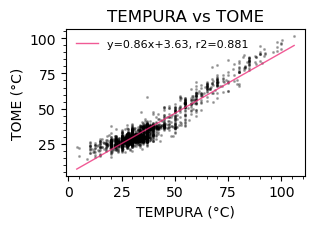

##GOSHA_OGT_Celsius vs TOME_Predicted_OGT_Celsius
# Number Entries without NANs:  12313
# Number Entries Not in TOME:  7404


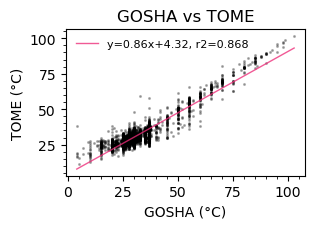

##TEMPURA_OGT_Celsius vs GOSHA_OGT_Celsius
# Number Entries without NANs:  4788
# Number Entries Not in TOME:  2853


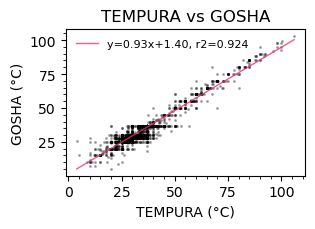

In [10]:
#### PLOT CORRELATIONS ####
out_dir = "/mnt/efs/fs1/software/Manuscript/GTDB_Data_Curation_and_Preprocessing/Result_Plots/"
## SETUP GRAPH PARAMETERS
# Define comparisons for graphing
corr_setup = [['TEMPURA_OGT_Celsius', "TOME_Predicted_OGT_Celsius"],
              ['GOSHA_OGT_Celsius', "TOME_Predicted_OGT_Celsius"],
              ['TEMPURA_OGT_Celsius', 'GOSHA_OGT_Celsius'],
             ]
# Axes labels for comparisions
axis_titles = [["TEMPURA (\u00B0C)", "TOME (\u00B0C)"], 
               ["GOSHA (\u00B0C)", "TOME (\u00B0C)"], 
               ["TEMPURA (\u00B0C)", "GOSHA (\u00B0C)"]]

## PLOT VARIOUS CORRELATIONS
for i,comparison in enumerate(corr_setup):
    plt.figure(figsize=(3.25,2.4))
    x_col = comparison[0]
    y_col = comparison[1]
    print(f"##{x_col} vs {y_col}")

    # DROP NANs
    no_nans_df = ogt_df.loc[(~ogt_df[x_col].isna()) & (~ogt_df[y_col].isna())]
    print("# Number Entries without NANs: ", no_nans_df.shape[0])

    # REMOVE TAXIDS IN TOME TRAINING
    no_nans_df = no_nans_df[~no_nans_df.Tax_ID.isin(gtdb_in_tome_training) & (no_nans_df.Tax_ID != "None")]
    print("# Number Entries Not in TOME: ",no_nans_df.shape[0] )
    #no_nans_df = no_nans_df.loc[no_nans_df[x_col] >= 60] # THERMOPHILE CHECK
    
    # GET CORRELATION AND BEST FIT LINE
    slope, intercept, r_value, p_value, std_err = stats.linregress(no_nans_df[x_col], 
                                                                   no_nans_df[y_col])
    r_squared = r_value ** 2
    
    # PLOT SCATTER AND BEST FIT
    sns.regplot(x=x_col, 
                y=y_col, 
                data=no_nans_df, 
                color="black",
                scatter_kws={'s': 1.5, "alpha":0.25},
                ci=None,
                line_kws={'label':f"y={slope:.2f}x+{intercept:.2f}, r2={r_squared:.3f}", "color":pub_red, "linewidth":1, "alpha":0.78})
    
    # Legend params
    plt.legend(fontsize=8, frameon=False)
    
    # Title
    graph_title = f"{axis_titles[i][0]} vs {axis_titles[i][1]}".replace(" (\u00B0C)", "")
    plt.title(graph_title,size = 12)

    # Format Axes
    plt.xlabel(axis_titles[i][0],size = 10)
    plt.ylabel(axis_titles[i][1],size = 10)
    plt.minorticks_on()

    # Format layout
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom = .05)
    plt.tight_layout()

    # Save
    plt.savefig(f"{out_dir}{graph_title.replace(' ', '_')}_Correlation_WithoutTOMETrainingTaxa.svg".replace('(\u00B0C)', ''), dpi = 400)
    plt.savefig(f"{out_dir}{graph_title.replace(' ', '_')}_Correlation_WithoutTOMETrainingTaxa.png".replace('(\u00B0C)', ''), dpi = 400)
    plt.show()

## III. <i>FIGURE 2B and S2: Phylogenetic Trees with OGT Overlay</i>

In [ ]:
#### DATA FOR REPRESENTATIVE GTDB GENOMES #### 
#1 if bacteria, 0 if archaea
bacteria = 1
if bacteria == 1:
    metadata_df = pd.read_csv('bac120_metadata_r214.tsv', header = 0, sep='\t') #bacteria
else:
    metadata_df = pd.read_csv('ar53_metadata_r214.tsv', header = 0, sep='\t') #archaea

#create dataframe of the temperature prediction data
temp_df = pd.read_csv('Predicted_Growth_Temperatures_Bacteria_Archaea.csv', sep = ',', header = 0)    
    
#filter to only GTDB representative genomes
gtdb_representative_metadata_df = metadata_df[metadata_df['gtdb_representative'] == 't']


#create dataframe for whether 23S, 16S, and 5S are represented 
if bacteria == 1:
    rRNA_df = pd.read_csv('gtdb_per_species_rRNA_bacteria.csv', header=None, names = ['accession','23s','16s','5s'], sep=',') #bacteria
else:
    rRNA_df = pd.read_csv('gtdb_per_species_rRNA_archaea.csv', header=None, names = ['accession','23s','16s','5s'], sep=',') #archaea

In [ ]:
#### CONDENSE DATA FOR TREE ####

#for cutting leaves from the tree, identify the taxonomic rank for binning
#tax_delimiter = ';s__' #genus
#tax_delimiter = ';g__' #family
#tax_delimiter = ';f__' #order
tax_delimiter = ';o__' #class
rank = 'class'

#get list of all unique taxonomies
all_taxonomies = set(gtdb_representative_metadata_df['gtdb_taxonomy'].tolist())

#get list of all unique taxonomies subject to rank cutoff
all_taxonomies_byrank = set([i[:i.find(tax_delimiter)] for i in all_taxonomies])

#get list of all phyla
all_phyla = set([i[:i.find(';c__')] for i in all_taxonomies])

#create dataframe of the condensed tree
data = []

for taxonomy in all_taxonomies_byrank:
    this_data = {}
    
    #collect all genome IDs in this taxonomy rank
    this_metadata = gtdb_representative_metadata_df[gtdb_representative_metadata_df['gtdb_taxonomy'].str.contains(taxonomy)]
    this_data['taxonomy_byrank'] = taxonomy
    
    #list all accessions that fall under this taxonomy rank
    this_data['accessions'] = this_metadata['accession'].tolist()
    
    #randomly choose one species to serve as a representative for this taxonomy rank
    this_data['representative_ID'] = random.choice(this_data['accessions'])
    this_data['phylum'] = taxonomy[taxonomy.find(';')+4:taxonomy.find(';c__')]
    
    
    #pull out the temp data for this taxonomy rank
    this_temp_df = temp_df[temp_df['genome_ID'].isin(this_data['accessions'])] 
    
    #check if there are annotations for any of these
    if len(this_temp_df) > 0:
        #collect the min, med, and max TOME values for this accessions in this rank
        this_data['tome_min'] = this_temp_df['Tome'].min()
        this_data['tome_ave'] = this_temp_df['Tome'].median() ####this is actually median
        this_data['tome_max'] = this_temp_df['Tome'].max()
        
        #collect the min, med, and max Tempura values for this accessions in this rank
        this_data['tempura_min'] = this_temp_df['tempura opt avg temp'].min()
        this_data['tempura_ave'] = this_temp_df['tempura opt avg temp'].median() ####this is actually median
        this_data['tempura_max'] = this_temp_df['tempura opt avg temp'].max()
        
        #collect the min, med, and max Gosha values for this accessions in this rank
        this_data['gosha_min'] = this_temp_df['gosha temp'].min()
        this_data['gosha_ave'] = this_temp_df['gosha temp'].median() ####this is actually median
        this_data['gosha_max'] = this_temp_df['gosha temp'].max()

    

        #1 if putatively collected from a hot isolation source. Do we average here? 
        #this_data['hot_isolation_source'] = 
    
    else:
        this_data['tome_min'] = 0
        this_data['tome_ave'] = 0.5
        this_data['tome_max'] = 1 
        
        this_data['tempura_min'] = 0
        this_data['tempura_ave'] = 0.5
        this_data['tempura_max'] = 1
        
        this_data['gosha_min'] = 0
        this_data['gosha_ave'] = 0.5
        this_data['gosha_max'] = 1   
        
        
    #pull out the rRNA data for this rank. ie how many rRNAs were identified in this rank
    #plus 1 on all to avoid divide by zero error
    this_rRNA_df = rRNA_df[rRNA_df['accession'].isin(this_data['accessions'])]
    if len(this_rRNA_df) > 0:
        this_data['23s_seqs'] = np.log2(len(this_rRNA_df[this_rRNA_df['23s']==True])+1)
        this_data['16s_seqs'] = np.log2(len(this_rRNA_df[this_rRNA_df['16s']==True])+1)
        this_data['5s_seqs'] = np.log2(len(this_rRNA_df[this_rRNA_df['5s']==True])+1)
    
    data.append(this_data)

tree_df = pd.DataFrame(data)

#deal with nan issue 
tree_df['tempura_min'] = tree_df['tempura_min'].fillna(0)
tree_df['tempura_ave'] = tree_df['tempura_ave'].fillna(0)
tree_df['tempura_max'] = tree_df['tempura_max'].fillna(0)

tree_df['gosha_min'] = tree_df['gosha_min'].fillna(0)
tree_df['gosha_ave'] = tree_df['gosha_ave'].fillna(0)
tree_df['gosha_max'] = tree_df['gosha_max'].fillna(0)

#condense the GTDB tree to just the rank defined above 
from ete3 import Tree

#load a tree
if bacteria == 1:
    t = Tree('bac120_reordered.newick', format=1, quoted_node_names=True) #bacteria
else:
    t = Tree('ar53_r214_reordered.newick', format=1, quoted_node_names=True) #archaea

#condense the tree to just the "representative_IDs" in the rank
t.prune(tree_df['representative_ID'].tolist())

#write the condensed tree
if bacteria == 1:
    t.write(format=1, outfile=f"bac120_{rank}.tree") #bacteria
else:
    t.write(format=1, outfile=f"ar53_{rank}.tree") #bacteria

In [ ]:
#determine the most abundant phyla in the condensed tree
from collections import Counter

def most_abundant_values(input_list, n=1):
    # Count occurrences of each element in the list
    counts = Counter(input_list)
    
    # Get the n most common elements
    most_common = counts.most_common(n)
    
    return most_common

phyla = tree_df['phylum'].tolist()
most_abundant_phyla = most_abundant_values(phyla, 8)

print(most_abundant_phyla)

In [ ]:
#create colormap dictionary for the phyla
if bacteria == 1:
    phyla_names  = ["Pseudomonadota","Patescibacteria","Bacteroidota", "Chloroflexota","Actinomycetota","Bacillota_A","Verrucomicrobiota", 
                    "Planctomycetota","Other"]
    phyla_colors = ["lightcoral", "darkorange", "gold", "palegreen", "cornflowerblue", "mediumpurple", "palevioletred","plum", "dimgray"]
    pylum_color_dict = dict(zip(phyla_names, phyla_colors))
else:
    phyla_names  = ["Thermoplasmatota","Thermoproteota","Halobacteriota", "Asgardarchaeota","Micrarchaeota","Nanoarchaeota","Aenigmatarchaeota", 
                    "Iainarchaeota","Other"]
    phyla_colors = ["lightcoral", "darkorange", "gold", "palegreen", "cornflowerblue", "mediumpurple", "palevioletred","plum", "dimgray"]
    pylum_color_dict = dict(zip(phyla_names, phyla_colors))

    
#use to label the nodes of the tree    
linecolor_dict={}
for i,accession in tree_df.iterrows():
    #make dot size log2 proportional to the number of species in the rank
    dot_size = (np.log2(len(accession['accessions']))+1) * 5
    if accession['phylum'] in pylum_color_dict:
        linecolor_dict[accession['representative_ID']] = {"color":'black',"size":dot_size}
    else:
        linecolor_dict[accession['representative_ID']] = {"color":'black', "size":dot_size}        

In [ ]:
#plot tree
import pycircos
import matplotlib.pyplot as plt
Tarc    = pycircos.Tarc
Tcircle = pycircos.Tcircle

#create tree at center of circos plot

if bacteria == 1:
    tree_file = f"bac120_{rank}.tree" #bacteria
else:
    tree_file = f"ar53_{rank}.tree" #archaea
growth_temps = 'Predicted_Growth_Temperatures_Bacteria_Archaea.csv'

tarc    = Tarc(tree=tree_file, format="newick", interspace=2)
tcircle = Tcircle(figsize=(12,12)) 

tcircle.add_tarc(tarc)
tcircle.set_tarcs()
tcircle.plot_tree(tarc.arc_id, rlim=(0,600), linewidth=0.5, linecolor="#606060", cladevisual_dict=linecolor_dict)

In [ ]:
#add the TOME values
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors

#Pull all the data that we'll need as lists
accessions = tree_df['representative_ID'].tolist()

tome_min = tree_df['tome_min'].tolist()
tome_ave = tree_df['tome_ave'].tolist()
tome_max = tree_df['tome_max'].tolist()

tempura_min = tree_df['tempura_min'].tolist()
tempura_ave = tree_df['tempura_ave'].tolist()
tempura_max = tree_df['tempura_max'].tolist()

gosha_min = tree_df['gosha_min'].tolist()
gosha_ave = tree_df['gosha_ave'].tolist()
gosha_max = tree_df['gosha_max'].tolist()

rRNA_23s_seqs = tree_df['23s_seqs'].tolist()
rRNA_16s_seqs = tree_df['16s_seqs'].tolist()
rRNA_5s_seqs = tree_df['5s_seqs'].tolist()

phyla = tree_df['phylum'].tolist()
phyla_colors = []
for phylum in phyla:
    if phylum in pylum_color_dict:
        phyla_colors.append(pylum_color_dict[phylum])
    else:
        phyla_colors.append(pylum_color_dict['Other'])

#Convert to dict using the ID of the representative species as the key
tome_min_dict = dict(zip(accessions, tome_min))
tome_ave_dict = dict(zip(accessions, tome_ave))
tome_max_dict = dict(zip(accessions, tome_max))

tempura_min_dict = dict(zip(accessions, tempura_min))
tempura_ave_dict = dict(zip(accessions, tempura_ave))
tempura_max_dict = dict(zip(accessions, tempura_max))

gosha_min_dict = dict(zip(accessions, gosha_min))
gosha_ave_dict = dict(zip(accessions, gosha_ave))
gosha_max_dict = dict(zip(accessions, gosha_max))

rRNA_23s_dict = dict(zip(accessions, rRNA_23s_seqs))
rRNA_16s_dict = dict(zip(accessions, rRNA_16s_seqs))
rRNA_5s_dict = dict(zip(accessions, rRNA_5s_seqs))

phyla_dict = dict(zip(accessions, phyla_colors))

#creat empty array for the circos plot representations
tome_min_values=[]
tome_ave_values=[]
tome_max_values=[]

tempura_min_values=[]
tempura_ave_values=[]
tempura_max_values=[]

gosha_min_values=[]
gosha_ave_values=[]
gosha_max_values=[]

rRNA_23s_values=[]
rRNA_16s_values=[]
rRNA_5s_values=[]

phyla_color_values=[]

#reorder the values according to the tree
for cladename in tarc.terminal_dict:
    #tome values
    tome_min_values.append(tome_min_dict[cladename])
    tome_ave_values.append(tome_ave_dict[cladename])
    tome_max_values.append(tome_max_dict[cladename])
    
    #tempura values
    tempura_min_values.append(tempura_min_dict[cladename])
    tempura_ave_values.append(tempura_ave_dict[cladename])
    tempura_max_values.append(tempura_max_dict[cladename])
    
    #gosha values
    gosha_min_values.append(gosha_min_dict[cladename])
    gosha_ave_values.append(gosha_ave_dict[cladename])
    gosha_max_values.append(gosha_max_dict[cladename])
    
    #number of rRNAs detected
    rRNA_23s_values.append(rRNA_23s_dict[cladename])
    rRNA_16s_values.append(rRNA_16s_dict[cladename])
    rRNA_5s_values.append(rRNA_5s_dict[cladename])
    
    #phyla
    phyla_color_values.append(phyla_dict[cladename])

#create the colormap
cmap1 = LinearSegmentedColormap.from_list("temps", [(0,"lightgray"),(.30,"white"),(1,"firebrick")], N=500) #30C is white, 100C is red

tcircle.barplot(tarc.arc_id, data=[1]*len(phyla_dict), raxis_range=(550,590), facecolor=phyla_color_values)
   

tcircle.heatmap(tarc.arc_id, data=tome_min_values, raxis_range=(600, 610), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=tome_ave_values, raxis_range=(610, 620), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=tome_max_values, raxis_range=(620, 630), cmap=cmap1)

tcircle.heatmap(tarc.arc_id, data=tempura_min_values, raxis_range=(650, 660), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=tempura_ave_values, raxis_range=(660, 670), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=tempura_max_values, raxis_range=(670, 680), cmap=cmap1, vmin=0, vmax=100)

tcircle.heatmap(tarc.arc_id, data=gosha_min_values, raxis_range=(700, 710), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=gosha_ave_values, raxis_range=(710, 720), cmap=cmap1, vmin=0, vmax=100)
tcircle.heatmap(tarc.arc_id, data=gosha_max_values, raxis_range=(720, 730), cmap=cmap1, vmin=0, vmax=100)

tcircle.barplot(tarc.arc_id, data=rRNA_23s_values, raxis_range=(750,780), facecolor="cornflowerblue")
tcircle.barplot(tarc.arc_id, data=rRNA_16s_values, raxis_range=(800,830), facecolor="royalblue")
tcircle.barplot(tarc.arc_id, data=rRNA_5s_values, raxis_range=(850,880), facecolor="midnightblue")

'''
#Set highlights for specific clades
highlight_dict={"100.0:p__Thermoplasmatota" : {"color":"lightcoral", "alpha":0.3, "fontsize":5, "label":"Thermoplasmatota"}}
tcircle.plot_highlight(tarc.arc_id, highlight_dict)
'''

In [ ]:
tcircle.figure
if bacteria==1:
    tcircle.figure.savefig(f"bacteria_{rank}.svg", format='svg', dpi=300)
    tcircle.figure.savefig(f"bacteria_{rank}.svg", format='svg', dpi=300)
else:
    tcircle.figure.savefig(f"archaea_{rank}.svg", format='svg', dpi=300)

tcircle.figure

## IV. <i>FIGURE 2C: Summary of GTDB Sample-Source Descriptions</i>

## PROCESSING: Orders
TOME Thermophiles in
New Thermophile OrdersA
No_GTDB_Description 52
Not_Thermophilic 130
Potentially_Thermophilic 308
Thermophilic 24


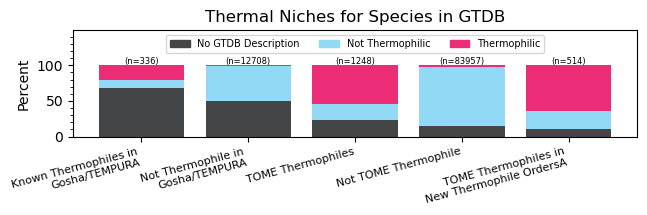

In [166]:
#### FIGURE 2C: Summary of GTDB Sample Descriptions ####

## COMBINE OGT PREDICTIONS WITH GTDB METADATA
all_meta_data = pd.concat([bact_meta, arc_meta], axis = 0)
col_order = ['GTDB_Genome_Accession', 'accession', 'ncbi_isolation_source', 'Manual_GTDB_Source_Classification', 
             'TOME_Predicted_OGT_Celsius', 'GOSHA_OGT_Celsius', 'TEMPURA_OGT_Celsius', 'GTDB_Taxonomy', 'Tax_ID']
ogt_meta_df = pd.merge(ogt_df.reset_index(), all_meta_data, how = "inner", left_on="GTDB_Genome_Accession", right_on="accession")
ogt_meta_df = ogt_meta_df[col_order]

## PREPARE TAXONOMY INFO
ogt_meta_df["Domains"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[0].split("d__")[-1])
ogt_meta_df["Phyla"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[1].split("p__")[-1])
ogt_meta_df["Classes"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[2].split("c__")[-1])
ogt_meta_df["Orders"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[3].split("o__")[-1])
ogt_meta_df["Families"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[4].split("f__")[-1])
ogt_meta_df["Genera"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[5].split("g__")[-1])
ogt_meta_df["Species"] = ogt_meta_df.GTDB_Taxonomy.apply(lambda x: x.split(";")[6].split("s__")[-1])
taxonomy_cols = ["Genera","Families","Orders","Classes","Phyla"]

## TABULATE NEW PHYLA
# ISOLATE KNOWN THERMOPHILES IN GOSHA AND/OR TEMPURA
known_thermo_df = ogt_meta_df[(ogt_meta_df["GOSHA_OGT_Celsius"] >= 60) | (ogt_meta_df.TEMPURA_OGT_Celsius >= 60)]
known_nonthermo_df = ogt_meta_df[(ogt_meta_df["GOSHA_OGT_Celsius"] < 60) | (ogt_meta_df.TEMPURA_OGT_Celsius < 60)]
tome_thermo_df = ogt_meta_df[(ogt_meta_df["TOME_Predicted_OGT_Celsius"] >= 60)]
tome_nonthermo_df = ogt_meta_df[(ogt_meta_df["TOME_Predicted_OGT_Celsius"] < 60)]

## TABULATE NEW CLADES
isolate_classes = {'No_GTDB_Description':"No GTDB Description", 
                   "Not_Thermophilic":"Not Thermohilic",
                   'Potentially_Thermophilic':"Potentially Thermophilic",
                   "Thermophilic":"Thermophilic"}

graph_contents = {}

# Counts for Bar 1
known_thermo_counts = [known_thermo_df["Manual_GTDB_Source_Classification"].value_counts()[x] for x in isolate_classes.keys()]
graph_contents["Known Thermophiles in\nGosha/TEMPURA"] = known_thermo_counts/np.sum(known_thermo_counts)*100

# Counts for Bar 2
known_nonthermo_counts = [known_nonthermo_df["Manual_GTDB_Source_Classification"].value_counts()[x] for x in isolate_classes.keys()]
graph_contents["Not Thermophile in\nGosha/TEMPURA"] = known_nonthermo_counts/np.sum(known_nonthermo_counts)*100

# Counts for Bar 3
tome_thermo_counts = [tome_thermo_df["Manual_GTDB_Source_Classification"].value_counts()[x] for x in isolate_classes.keys()]
graph_contents["TOME Thermophiles"] = tome_thermo_counts/np.sum(tome_thermo_counts)*100

# Counts for Bar 4
tome_nonthermo_counts = [tome_nonthermo_df["Manual_GTDB_Source_Classification"].value_counts()[x] for x in isolate_classes.keys()]
graph_contents["Not TOME Thermophile"] = tome_nonthermo_counts/np.sum(tome_nonthermo_counts)*100

# Totals for plot labels
total_counts = [np.sum(x) for x in [known_thermo_counts, known_nonthermo_counts, tome_thermo_counts, tome_nonthermo_counts]]

# Counts for Bar 5-6
for tax_col in ['Orders']:
    print(f"## PROCESSING: {tax_col}")
    known_items = list(known_thermo_df[tax_col].unique())
    known_counts = known_thermo_df.loc[known_thermo_df.TOME_Predicted_OGT_Celsius >= 60].Manual_GTDB_Source_Classification.value_counts() #known_thermo_df.Manual_GTDB_Source_Classification.value_counts()
    unknown_counts = ogt_meta_df.loc[(~ogt_meta_df[tax_col].isin(known_items))&(ogt_meta_df.TOME_Predicted_OGT_Celsius >= 60)].Manual_GTDB_Source_Classification.value_counts()
    count_dict = {#f"TOME Thermophiles\nnot in Gosha/TEMPURA":known_counts, 
                  f"TOME Thermophiles in\nNew Thermophile {tax_col}A":unknown_counts}
    
    for key,counts in count_dict.items():
        ordered_counts = []
        print(key)
        for label in isolate_classes.keys():
            temp_counts = counts[label]
            print(label, temp_counts)
            ordered_counts.append(temp_counts)
        graph_contents[key] = ordered_counts/np.sum(ordered_counts)*100 #ordered_counts
        total_counts.append(np.sum(ordered_counts))
## GRAPH
categories = list(graph_contents.keys())
labels = ["No GTDB Description", 
          'Not Thermophilic', 
          'Thermophilic', 
          'Thermophilic']

# Setup for plot
n_categories = len(graph_contents)
n_types = len(labels)
ind = np.arange(n_categories)
width = 0.7

fig, ax = plt.subplots(figsize=(6.5, 2.25))

# Colors for each type
colors = [pub_darkest_grey, 
          pub_cyan, 
          pub_red, 
          pub_red] 

# Stacked bar plot
bottom_values = np.zeros(n_categories)  # Correct initialization for stacking
for i in range(n_types):
    type_values = [graph_contents[category][i] for category in categories]
    ax.bar(ind, type_values, bottom=bottom_values, label=labels[i], color=colors[i])
    bottom_values += np.array(type_values)
    
ax.set_ylabel('Percent', size=10)
ax.set_ylim(0, 149)  # Ensure this range is appropriate for your data
ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())
ax.set_title('Thermal Niches for Species in GTDB', size=12)
ax.set_xticks(ind)
ax.set_xticklabels(categories, rotation=15, ha="right", size=8)

# ADD LABELS
for i,total in enumerate(total_counts):
    ax.text(i,105, f"(n={total})", ha = "center", va = "center", size = 6)
# LEGEND FORMATTING
legend_patches = [mpatches.Patch(color=color, label=label) for label, color in zip(labels[:-1], colors[:-1])]
legend = ax.legend(handles=legend_patches, loc='upper center', bbox_to_anchor=(0.5, 1), fontsize=7, ncol=3)

plt.subplots_adjust(left=0.00, right=1, top=0.99, bottom = .01)
plt.tight_layout()
plt.savefig("Figure_2C.svg")
plt.show()
